In [1]:
import os
import subprocess
import bt
import datetime as dt


tickers = subprocess.run(args=["python", os.getcwd() + "\\data_cleaning.py"],text=True,stdout=subprocess.PIPE)

results = tickers.stdout.strip('""[]\n').split(', ')

symbols = [element.strip("'\"") for element in results]

current_date = dt.date.today()
start_date = current_date - dt.timedelta(days=365)
start = (start_date - dt.timedelta(days=round((1.5*50)-1,0)))

if start.isoweekday() == 6:
    start = start - dt.timedelta(days=1)
elif start.isoweekday() == 7:
    start = start + dt.timedelta(days=1)


df = bt.get(symbols,start=start.strftime("%Y-%m-%d"))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


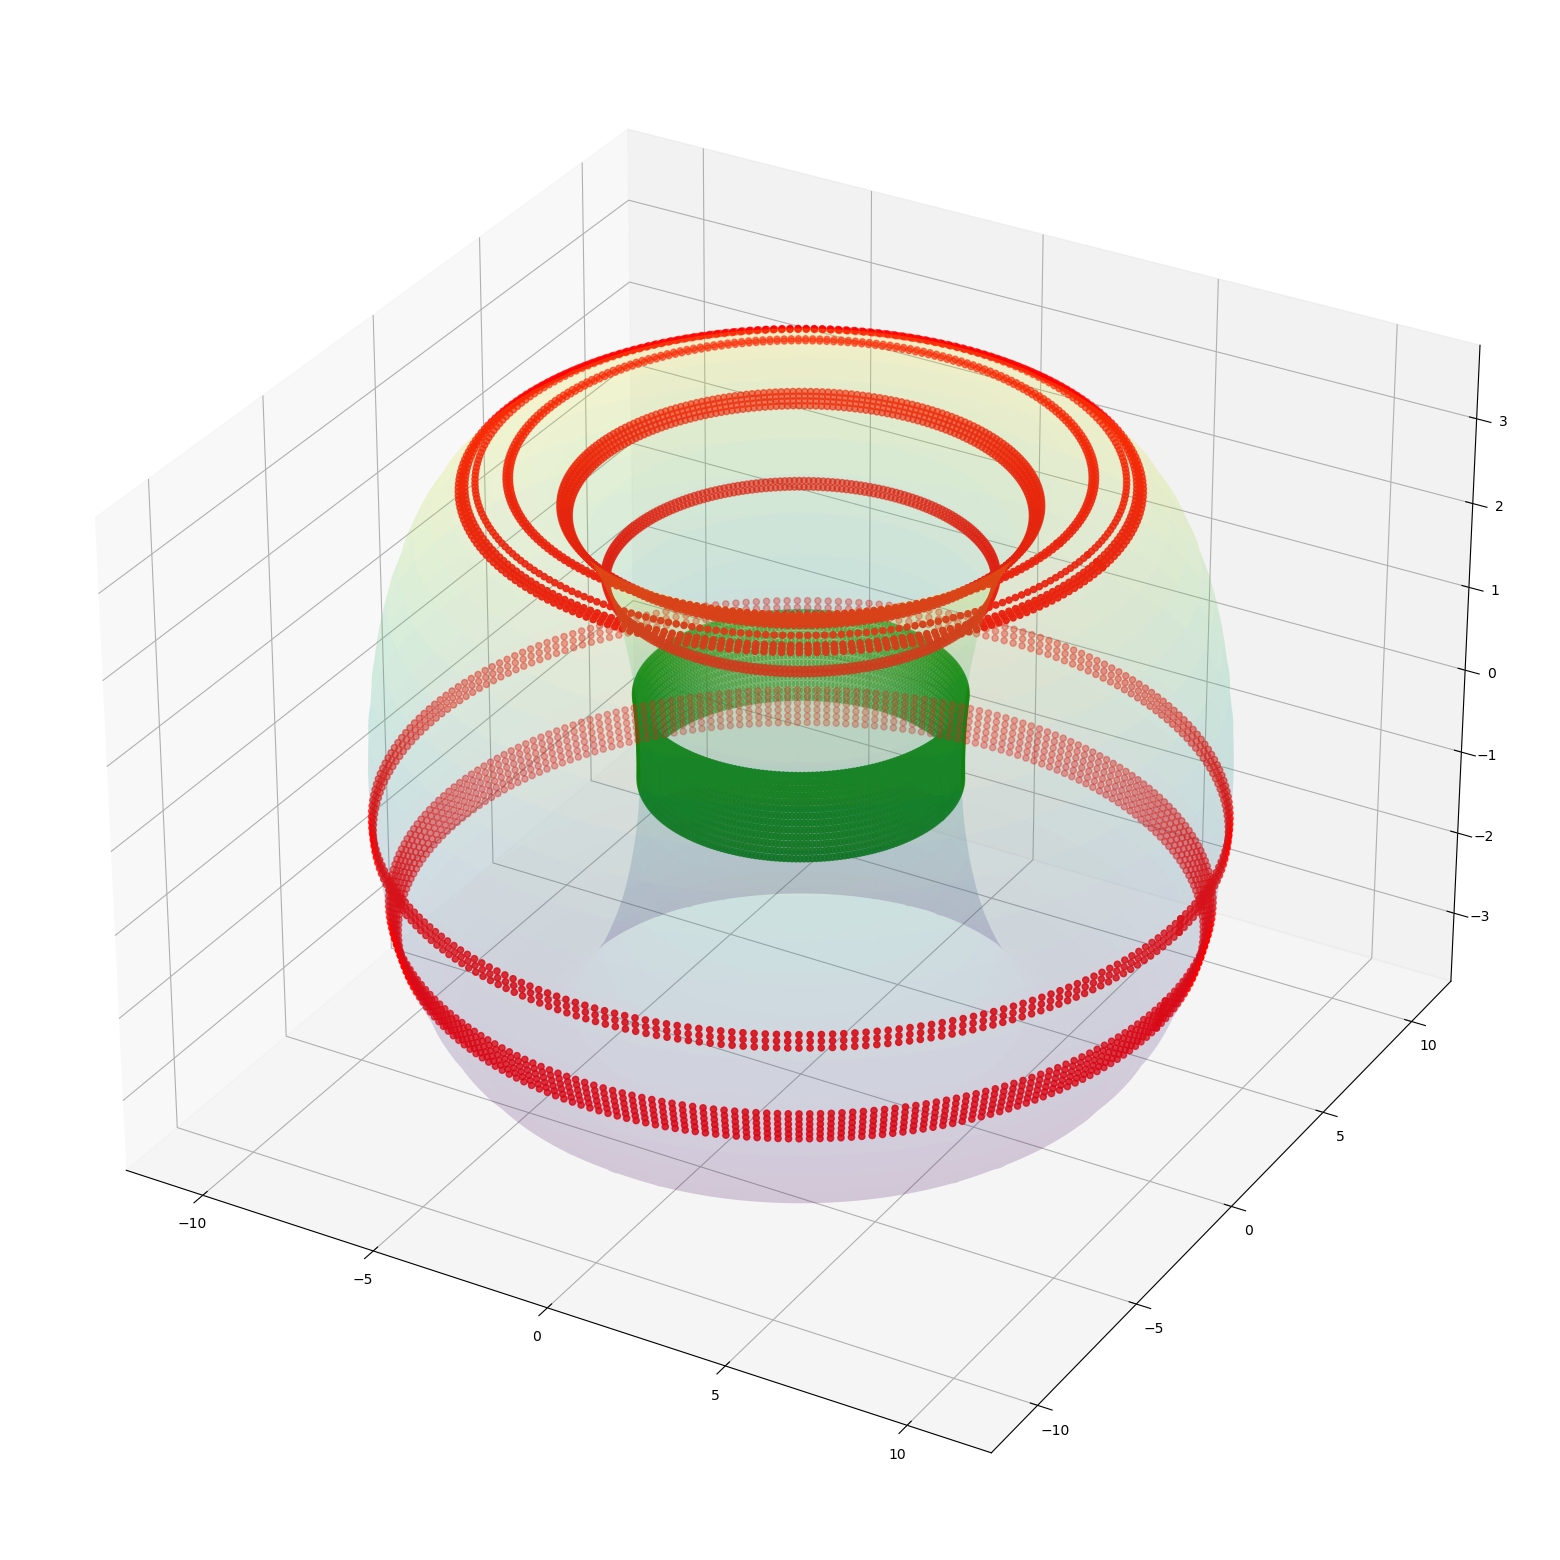

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    rolling_mean = ((rolling_mean - rolling_mean.min()) / (rolling_mean.max() - rolling_mean.min())) * big
    rolling_std = ((rolling_std - rolling_std.min()) / (rolling_std.max() - rolling_std.min())) * big

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.1, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions


big = 2 * np.pi
df = (df - df.loc[df.index == start_date.strftime("%Y-%m-%d")].values)

# Calculate the mean and standard deviation 

highest = df_filter.loc[df_filter.index >= start_date.strftime("%Y-%m-%d")].max()
lowest = df_filter.loc[df_filter.index >= start_date.strftime("%Y-%m-%d")].min()

norm_price = ((df_filter - lowest)/(highest - lowest))*(2*np.pi)

rolling_mean = df.rolling(window=50).mean()
rolling_std = df.rolling(window=50).std()

buy_signal = df < rolling_mean - (2 * rolling_std)
sell_signal = df > rolling_mean + (2 * rolling_std)

buy_signal = buy_signal.loc[buy_signal.index >= start_date.strftime("%Y-%m-%d")]
sell_signal = sell_signal.loc[sell_signal.index >= start_date.strftime("%Y-%m-%d")]

ticker_action = pd.DataFrame(buy_signal.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

plot_torus("cvx",big,rolling_mean.loc[rolling_mean.index >= start_date.strftime("%Y-%m-%d")],
           rolling_std.loc[rolling_std.index >= start_date.strftime("%Y-%m-%d")],buy_signal,sell_signal,len(ticker_action))

In [11]:
symbols

['CDLX',
 'CVX',
 'PYPL',
 'MOD',
 'CALM',
 'INDA',
 'ANF',
 'YMM',
 'CORT',
 'DLO',
 'GNTX',
 'INCY']

In [ ]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(df.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action

tailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

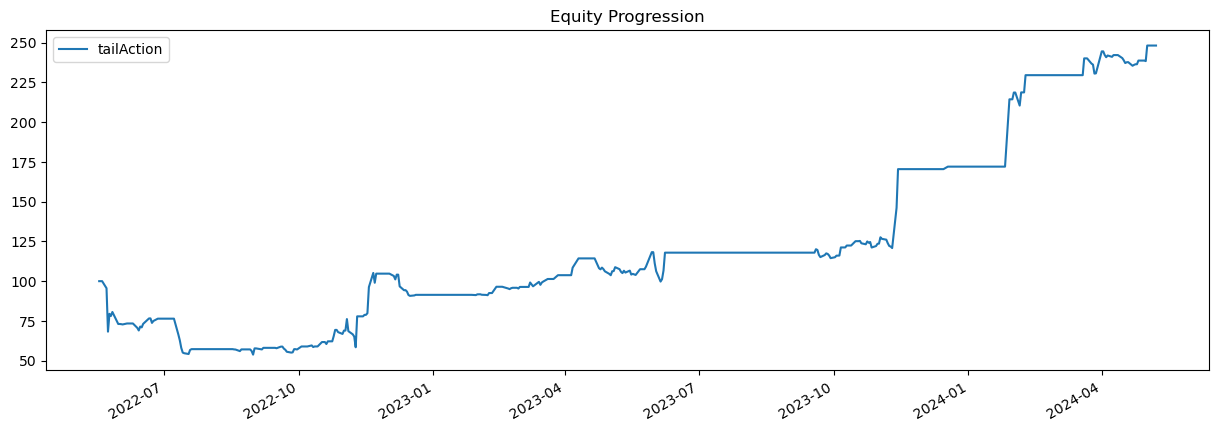

In [30]:
import os
import subprocess
import bt
import datetime as dt
import numpy as np
import json

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

tickers = subprocess.run(args=["python", os.getcwd() + "\\data_cleaning.py"],text=True,stdout=subprocess.PIPE)

results = tickers.stdout.strip('""[]\n').split(', ')

symbols = [element.strip("'\"") for element in results]

current_date = dt.date.today()
start_date = current_date - dt.timedelta(days=720)

num_day = start_date.isoweekday()

if num_day > 5:
    start_date = start_date - dt.timedelta(days=num_day-5)

start = (start_date - dt.timedelta(days=round((1.5*50)-1,0)))

if start.isoweekday() == 6:
    start = start - dt.timedelta(days=1)
elif start.isoweekday() == 7:
    start = start + dt.timedelta(days=1)

df = bt.get(symbols,start=start.strftime("%Y-%m-%d"))

df_filter = (df - df.loc[df.index == start_date.strftime("%Y-%m-%d")].values)

rolling_mean = df_filter.rolling(window=50).mean()
rolling_std = df_filter.rolling(window=50).std()

buy_signal = df_filter < rolling_mean - (2 * rolling_std)
sell_signal = df_filter > rolling_mean + (2 * rolling_std)

buy_signal = buy_signal.loc[buy_signal.index >= start_date.strftime("%Y-%m-%d")]
sell_signal = sell_signal.loc[sell_signal.index >= start_date.strftime("%Y-%m-%d")]
# bt.algos.WeighSpecified(**weights)


strat = bt.Strategy('tailAction', [bt.algos.SelectWhere(buy_signal),
                                   bt.algos.WeighEqually(),
                                   bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(strat, df.loc[df.index >= start_date.strftime("%Y-%m-%d")],integer_positions=False, progress_bar=True)

# and let's run it!
res = bt.run(t)

res.plot()


In [32]:
res.display()

Stat                 tailAction
-------------------  ------------
Start                2022-05-18
End                  2024-05-08
Risk-free rate       0.00%

Total Return         148.17%
Daily Sharpe         1.11
Daily Sortino        2.06
CAGR                 58.48%
Max Drawdown         -46.20%
Calmar Ratio         1.27

MTD                  3.96%
3m                   13.47%
6m                   103.17%
YTD                  44.26%
1Y                   130.77%
3Y (ann.)            58.48%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  58.48%

Daily Sharpe         1.11
Daily Sortino        2.06
Daily Mean (ann.)    60.87%
Daily Vol (ann.)     55.01%
Daily Skew           2.44
Daily Kurt           37.48
Best Day             33.24%
Worst Day            -28.58%

Monthly Sharpe       1.36
Monthly Sortino      3.82
Monthly Mean (ann.)  75.35%
Monthly Vol (ann.)   55.38%
Monthly Skew         1.46
Monthly Kurt         4.13
Best Month           56.72%
Worst Month          -25.0

In [33]:
res.get_security_weights().head(n=50)

,anf,incy,gntx,cvx,cdlx,ymm,dlo,inda,pypl,calm,cort,mod
2022-05-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
import json
import os

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

weights = criteria["Portfolio Weights"]

1-sum(list(weights.values()))

0.3294